In [123]:
import urllib.request, time, re, random, hashlib, nltk, functools
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk import word_tokenize
from nltk.corpus import wordnet as wn
from sklearn.svm import LinearSVC as LSVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import BaggingClassifier as BC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.learning_curve import learning_curve
from sklearn import grid_search
%matplotlib notebook

### 1.Get data

In [3]:
# Compassionate Caching inspired by 
# http://lethain.com/an-introduction-to-compassionate-screenscraping/

last_fetched_at = None

def fetch(url):
    """Load the url compassionately."""
    
    global last_fetched_at
    
    url_hash = hashlib.sha1(url.encode()).hexdigest()
    filename = 'cache-file-{}'.format(url_hash)
#     print(url_hash)
    try:
        with open(filename, 'r') as f:
            result = f.read()
            if len(result) > 0:
                print("Retrieving from cache:", url)
                return result
    except:
        pass
    
    print("Loading:", url)
    wait_interval = random.randint(3000,10000)
    if last_fetched_at is not None:
        now = time.time()
        elapsed = now - last_fetched_at
        if elapsed < wait_interval:
            time.sleep((wait_interval - elapsed)/1000)
        
    user_agent = 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)'
    headers = { 'User-Agent' : user_agent }
    req = urllib.request.Request(url, headers = headers)
    last_fetched_at = time.time()
    with urllib.request.urlopen(req) as response:
        result = str(response.read())
        with open(filename, 'w') as f:
            f.write(result)
        return result

In [46]:
# Get a set of links for news articles
def get_news_links(link):
    articles = fetch(link)
    soup = BeautifulSoup(articles, 'html.parser')
    links = set([])
    for a in soup.find_all("a"):
        sub_link = a.get("href")
        if sub_link != None and sub_link.startswith("/story/news/"):
            links.add('http://www.usatoday.com' + sub_link)
    return links

def news_scraper():
    links = get_news_links("http://www.usatoday.com/news/")
    for link in links:
        sub_set = get_news_links(link)
        links = links.union(sub_set)
    return links

In [37]:
news_set = news_scraper()
news_set = set([news for news in news_set if "corrections-clarifications" not in news][:100])

Retrieving from cache: http://www.usatoday.com/news/
Retrieving from cache: http://www.usatoday.com/story/news/2016/03/15/after-their-child-ended-up-trash-couple-get-28m/81800790/
Retrieving from cache: http://www.usatoday.com/story/news/politics/onpolitics/2016/02/04/politics-stressing-you-out-our-2016-coloring-book-here/79843572/
Retrieving from cache: http://www.usatoday.com/story/news/2016/02/13/state-teacher-background-lookup-resources/80355350/
Retrieving from cache: http://www.usatoday.com/story/news/nation/2014/07/01/usa-today-staff-twitter/11889933/
Retrieving from cache: http://www.usatoday.com/story/news/politics/elections/2016/03/15/donald-trump-ohio-florida-marco-rubio-john-kasich-ted-cruz-north-carolina-illinois-missouri/81808136/
Retrieving from cache: http://www.usatoday.com/story/news/2016/02/25/dea-riverside-wiretaps-scaled-back/80891460/
Retrieving from cache: http://www.usatoday.com/story/news/2013/01/09/corrections-clarifications/1821023/
Retrieving from cache: htt

In [4]:
news_set  = {'http://www.usatoday.com/story/news/2015/06/09/mom-baby-reunited-in-hospital-after-traumatic-tree-incident/28771335/',
 'http://www.usatoday.com/story/news/2015/06/18/charleston-shooting-lone-wolf-hate-crime/28926927/',
 'http://www.usatoday.com/story/news/2015/07/16/untested-rape-kits-evidence-across-usa/29902199/',
 'http://www.usatoday.com/story/news/2015/07/18/5-things-you-need-know-weekend/30080047/',
 'http://www.usatoday.com/story/news/2015/07/28/joyce-mitchell-prison-seamstress-accused--aiding-escape--richard-matt-and-david-sweat-expected--make-plea-deal/30775927/',
 'http://www.usatoday.com/story/news/2015/07/30/police-pursuits-fatal-injuries/30187827/',
 'http://www.usatoday.com/story/news/2015/08/19/sustainable-marijuana-news21-water/31545469/',
 'http://www.usatoday.com/story/news/2015/11/05/fast-food-strike/75155278/',
 'http://www.usatoday.com/story/news/2015/11/11/dea-wiretap-operation-riverside-california/75484076/',
 'http://www.usatoday.com/story/news/2015/11/17/supplements-charges-justice-investigation/75943252/',
 'http://www.usatoday.com/story/news/2015/11/24/chicago-police-superintendent-calls-for-firing-dante-servin-rekia-boyd-case/76295730/',
 'http://www.usatoday.com/story/news/2015/12/09/illegal-dea-wiretap-riverside-money-laundering/77050442/',
 'http://www.usatoday.com/story/news/2016/01/15/cdc-issues-travel-alert-zika-virus-which-linked-birth-defects/78849556/',
 'http://www.usatoday.com/story/news/2016/01/26/whacked-blizzard-2016-how-did-major-cities-cope/79351244/',
 'http://www.usatoday.com/story/news/2016/02/02/microcephaly-zika-virus-explainer/79690782/',
 'http://www.usatoday.com/story/news/2016/02/03/zika-q-and-a/79751476/',
 'http://www.usatoday.com/story/news/2016/02/03/zika-virus-forces-red-cross-change-blood-donation-policy/79771118/',
 'http://www.usatoday.com/story/news/2016/02/04/sperm-bank-drafts-zika-virus-policy/79830666/',
 'http://www.usatoday.com/story/news/2016/02/05/brazil-study-active-zika-virus-found-urine-saliva/79879076/',
 'http://www.usatoday.com/story/news/2016/02/05/un-zika-affected-nations-must-increase-contraception-access/79869242/',
 'http://www.usatoday.com/story/news/2016/02/10/cdc-confirms-link-between-zika-microcephaly-brazilian-babies-who-died/80179898/',
 'http://www.usatoday.com/story/news/2016/02/13/state-teacher-background-lookup-resources/80355350/',
 'http://www.usatoday.com/story/news/2016/02/13/timeline-supreme-court-associate-justice-antonin-scalia/80349734/',
 'http://www.usatoday.com/story/news/2016/02/16/experts-dismiss-claims-pesticide-not-zika-causes-birth-defects/80451116/',
 'http://www.usatoday.com/story/news/2016/02/16/who-says-56-million-needed-fight-zika/80480178/',
 'http://www.usatoday.com/story/news/2016/02/23/legislative-roundup-abortion-medical-marijuana-bills-advance/80823416/',
 'http://www.usatoday.com/story/news/2016/02/23/texas-hospitals-develop-rapid-zika-test/80776382/',
 'http://www.usatoday.com/story/news/2016/02/25/study-zika-linked-extensive-birth-defects-throughout-body/80850442/',
 'http://www.usatoday.com/story/news/2016/02/29/zika-can-cause-guillain-barre-syndrome-study-shows/81103754/',
 'http://www.usatoday.com/story/news/2016/03/04/study-provides-strongest-evidence-yet-linking-zika-birth-defects/81318418/',
 'http://www.usatoday.com/story/news/2016/03/10/rape-kit-reforms-flood-state-legislatures/81326714/',
 'http://www.usatoday.com/story/news/2016/03/13/trump-pulls-man-out-crowd-tout-legal-immigration/81727540/',
 'http://www.usatoday.com/story/news/2016/03/15/cdc-issues-new-guidelines-opiate-prescribing-reduce-abuse-overdoses/81809704/',
 'http://www.usatoday.com/story/news/2016/03/15/illinois-voters-go-polls-tight-races/81802380/',
 'http://www.usatoday.com/story/news/education/2016/02/14/state-backlog-lets-educators-keep-licenses/79369052/',
 'http://www.usatoday.com/story/news/education/2016/02/24/educators-do-little-time-sex-crimes/79369888/',
 'http://www.usatoday.com/story/news/local/2016/02/23/ga-house-passes-untested-rape-kits/80822512/',
 'http://www.usatoday.com/story/news/local/roseburg-college-shooting/2015/10/02/roseburg-shooting-dont-even-want-know-names-yet/73206926/',
 'http://www.usatoday.com/story/news/nation-now/2015/02/04/up-house-auction/22847361/',
 'http://www.usatoday.com/story/news/nation-now/2015/04/06/fraternity-misconduct-problem-solutions/70492812/',
 'http://www.usatoday.com/story/news/nation-now/2015/05/21/parallel-parking-driving-tests/27671165/',
 'http://www.usatoday.com/story/news/nation-now/2015/05/26/lily-pulitzer-headquarters-target-fat-shaming/27967717/',
 'http://www.usatoday.com/story/news/nation-now/2015/06/12/wrongskin-naacp-transracial/71114360/',
 'http://www.usatoday.com/story/news/nation-now/2015/06/30/kkk-rally-south-carolina-statehouse-confederate-flag/29510543/',
 'http://www.usatoday.com/story/news/nation-now/2015/08/03/subway-jared-fogle-allegation-sex-teen/31049233/',
 'http://www.usatoday.com/story/news/nation-now/2015/11/07/where-find-veterans-day-freebies/75083968/',
 'http://www.usatoday.com/story/news/nation-now/2016/02/06/deacons-of-defense-robert-hicks/78955042/',
 'http://www.usatoday.com/story/news/nation-now/2016/02/25/new-jersey-woman-tossed-traffic-animal-cruelty-death-jail/80920708/',
 'http://www.usatoday.com/story/news/nation-now/2016/03/15/three-top-phoenix-va-hospital-execs-fired/81838700/',
 'http://www.usatoday.com/story/news/nation/2015/01/06/weather-winter-arctic-blast/21325349/',
 'http://www.usatoday.com/story/news/nation/2015/03/11/marine-corps-special-operations-command-history/70149558/',
 'http://www.usatoday.com/story/news/nation/2015/05/19/fittest-metro-areas-washington-dc-tops-indianapolis-bottom/27253353/',
 'http://www.usatoday.com/story/news/nation/2015/06/24/walmart-foundation-summer-meal/29175811/',
 'http://www.usatoday.com/story/news/nation/2015/07/16/international-space-station-debris/30231057/',
 'http://www.usatoday.com/story/news/nation/2015/07/26/fishing-boat-missing/30705179/',
 'http://www.usatoday.com/story/news/nation/2015/08/31/voices-scene--burning-man/71453610',
 'http://www.usatoday.com/story/news/nation/2015/09/02/voices-new-orleans-katrina-racial-disparity/71416846/',
 'http://www.usatoday.com/story/news/nation/2015/09/03/saudi-king-salman-visit-president-obama-royal-fashion-and-goes-big/71655868/',
 'http://www.usatoday.com/story/news/nation/2015/10/23/five-things-to-know-friday/74120440/',
 'http://www.usatoday.com/story/news/nation/2015/11/18/syria-refugee-family-south-florida-republicans-paris-attacks/75982996/',
 'http://www.usatoday.com/story/news/nation/2015/12/17/baltimore-after-mistrial-whats-next/77479158/',
 'http://www.usatoday.com/story/news/nation/2016/01/05/small-oregon-town-supports-ranchers-not-occupation/78299848/',
 'http://www.usatoday.com/story/news/nation/2016/02/03/who-sexual-transmission-zika/79744862/',
 'http://www.usatoday.com/story/news/nation/2016/03/15/reports-washington-dc-metro-close-24-hours-inspection/81823344/',
 'http://www.usatoday.com/story/news/politics/2015/01/06/house-ethics-rules-gop/21340709/',
 'http://www.usatoday.com/story/news/politics/2015/04/13/gao-duplication-nation-report-2015/25713359/',
 'http://www.usatoday.com/story/news/politics/2015/07/31/former-lawmakers-still-have-campaign-cash/30943329/',
 'http://www.usatoday.com/story/news/politics/2015/09/01/trailing-russians-obama-moves-fill-icebreaker-gap/71520950/',
 'http://www.usatoday.com/story/news/politics/2016/02/08/obama-asks-emergency-zika-funding/80002570/',
 'http://www.usatoday.com/story/news/politics/2016/02/24/obama-cant-close-guantanamo-bay-but-could-empty-it-out/80856734/',
 'http://www.usatoday.com/story/news/politics/2016/03/15/obama-trump-campaign-rhetoric-american-brand-st-patricks-day/81820566/',
 'http://www.usatoday.com/story/news/politics/elections/2016/02/01/mike-huckabee-republican-presidential-campaign/79651090/',
 'http://www.usatoday.com/story/news/politics/elections/2016/02/03/rick-santorum-republican-race/79653722/',
 'http://www.usatoday.com/story/news/politics/elections/2016/02/25/texas-primary-cruz-trump-super-tuesday/80879208/',
 'http://www.usatoday.com/story/news/politics/elections/2016/03/15/marco-rubio-florida-primary-election-2016/81805834/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/01/06/marco-rubio-boots-carly-fiorina-rand-paul-ted-cruz/78366570/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/01/19/2016-primary-debate-schedule/79020938/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/01/20/bernie-sanders-paleo-before-paleo-thing/79065692/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/01/22/marco-rubio-jimmy-fallon-tonight-tonight-show/79164536/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/02/02/rubio-iowas-support-sends-clear-message/79682364/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/02/03/whos-real-progressive-sanders-and-clinton-get-heated-twitter/79788274/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/02/13/ted-cruz-marco-rubio-south-carolina-debate/80363414/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/03/donald-trump-hands-rubio-debate/81297208/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/08/networks-cover-trump-speech-not-clinton/81512482/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/09/poll-rubio-trump-florida-ohio-kasich/81529778/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/10/what-time-is-the-republican-debate/81538606/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/14/poll-donald-trump-marco-rubio-florida/81763362/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/15/memorable-moments-marco-rubio-campaign/81768270/',
 'http://www.usatoday.com/story/news/politics/onpolitics/2016/03/15/twitter-marco-rubio-dropout/81838598/',
 'http://www.usatoday.com/story/news/world/2015/01/08/charlie-hebdo-europe-muslim-tensions/21394923/',
 'http://www.usatoday.com/story/news/world/2015/01/19/cuba-us-congressional-delegation-diplomatic-talks/22012429/',
 'http://www.usatoday.com/story/news/world/2015/03/05/last-ebola-patient-released-liberia/24421305/',
 'http://www.usatoday.com/story/news/world/2015/05/21/china-plane-islands/27701571/',
 'http://www.usatoday.com/story/news/world/2015/06/10/spyware-targeted-iran-talks-linked-to-israel-kaspersky-duqu-20/71001250/',
 'http://www.usatoday.com/story/news/world/2015/06/12/malaysia-naked-tourists/71109546/',
 'http://www.usatoday.com/story/news/world/2015/08/17/army-ranger-school-women-graduate/31887987/',
 'http://www.usatoday.com/story/news/world/2015/09/22/ukrainian-tatars-blockade-russian-held-crimea/72629660/',
 'http://www.usatoday.com/story/news/world/2015/10/28/arab-jewish-preschool-island-sanity-amid-violence-parents-say/74668290/',
 'http://www.usatoday.com/story/news/world/2016/01/04/bahrain-severs-ties-saudi-arabia/78250284/',
 'http://www.usatoday.com/story/news/world/2016/02/18/pope-suggests-contraception-can-condoned-zika-crisis/80556884/'}

In [ ]:
# Get a set of links for opinion articles
def get_opinion_links(link):
    articles = fetch(link)
    soup = BeautifulSoup(articles, 'html.parser')
    links = set([])
    for a in soup.find_all("a"):
        sub_link = a.get("href")
        if sub_link != None and sub_link.startswith("/story/opinion/"):
            links.add('http://www.usatoday.com' + sub_link)
    return links

def opinion_scraper():
    links = get_opinion_links("http://www.usatoday.com/opinion/")
    for link in links:
        sub_set = get_opinion_links(link)
        links = links.union(sub_set)
    return links

In [5]:
opinion_set = {'http://www.usatoday.com/story/opinion/2013/09/16/syria-irs-lerner-column/2816277/',
 'http://www.usatoday.com/story/opinion/2013/09/25/grocery-store-detroit-irs-column/2868797/',
 'http://www.usatoday.com/story/opinion/2014/05/12/president-obama-irs-scandal-watergate-column/8968317/',
 'http://www.usatoday.com/story/opinion/2014/08/28/russia-ukraine-nato-vladimir-putin-president-obama-editorials-debates/14766425/',
 'http://www.usatoday.com/story/opinion/2015/05/25/caption-contest-youtoon/1568271/',
 'http://www.usatoday.com/story/opinion/2015/07/23/highway-funding-oil-gasoline-tax-fix-congress-editorials-debates/30579385/',
 'http://www.usatoday.com/story/opinion/2015/12/21/cdc-opioids-heroin-overdoses-doctors-editorials-debates/77708774/',
 'http://www.usatoday.com/story/opinion/2016/02/01/mia-love-single-subject-rule-constitutional-amendment--reynolds-column/79605158/',
 'http://www.usatoday.com/story/opinion/2016/02/01/super-bowl-football-brain-damage-immoral-watch-column/79654086/',
 'http://www.usatoday.com/story/opinion/2016/02/04/obama--wrong-solitary-confinement-column/79649416/',
 'http://www.usatoday.com/story/opinion/2016/02/04/trump-sanders-mccain-new-hampshire-mavericks-column/79832920/',
 'http://www.usatoday.com/story/opinion/2016/02/07/journalists-jail-murder-censorship-turkey-editorials-debates/79844586/',
 'http://www.usatoday.com/story/opinion/2016/02/07/new-hampshire-primary-100-years-old-rebel-role-dante-scala-column/79967400/',
 'http://www.usatoday.com/story/opinion/2016/02/07/police-use-of-lethal-force-tellusatoday-your-say/79978876/',
 'http://www.usatoday.com/story/opinion/2016/02/07/turkish-ambassador-journalists-turkey-editorials-debates/79845450/',
 'http://www.usatoday.com/story/opinion/2016/02/07/voter-anger-elections-super-bowl-second-look/79967622/',
 'http://www.usatoday.com/story/opinion/2016/02/08/bill-de-blasio-chirlane-mccray-opioid-crisis-treatment-naloxone-overdoses-column/79972594/',
 'http://www.usatoday.com/story/opinion/2016/02/08/cal-thomas-elections-2016-god-religion-politics-evangelical-voters-column/79943324/',
 'http://www.usatoday.com/story/opinion/2016/02/08/federal-deficit-our-view-editorials-debates/80024164/',
 'http://www.usatoday.com/story/opinion/2016/02/08/federal-deficits-economy-governemtn-spending-editorials-debates/80032380/',
 'http://www.usatoday.com/story/opinion/2016/02/08/irs-tea-party-targeting-lois-lerner-corruption--obama-glenn-reynolds-column/79967098/',
 'http://www.usatoday.com/story/opinion/2016/02/08/martin-shkreli-drug-prices-your-say/80026236/',
 'http://www.usatoday.com/story/opinion/2016/02/08/primary-voting-presidential-election-tellusatoday-your-say/80026468/',
 'http://www.usatoday.com/story/opinion/2016/02/09/bernie-sanders-hillary-clinton-new-hampshire-column/80094342/',
 'http://www.usatoday.com/story/opinion/2016/02/09/beyonce-ads-super-bowl-colbert-corden-meyers-conan-jessica-williams/80052554/',
 'http://www.usatoday.com/story/opinion/2016/02/09/military-medical-battlefield-training-live-tissue-training-animal-rights-column/80018116/',
 'http://www.usatoday.com/story/opinion/2016/02/09/new-hampshire-primary-donald-trump-bernie-sanders-editorials-debates/80091284/',
 'http://www.usatoday.com/story/opinion/2016/02/09/obama-administration-least-transparent-epa-state-doj-clinton-benghazi-column/80050428/',
 'http://www.usatoday.com/story/opinion/2016/02/09/our-votes-matter-voter-id-citizens-united-voting-rights-act-democracy-awakens-column/80068028/',
 'http://www.usatoday.com/story/opinion/2016/02/09/solitary-confinement-federal-prisons-tellusatoday-your-say/80086320/',
 'http://www.usatoday.com/story/opinion/2016/02/09/super-bowl-50-your-say/80086738/',
 'http://www.usatoday.com/story/opinion/2016/02/09/trump-sanders-wins-new-hampshire-economic-anxiety-column/80088548/',
 'http://www.usatoday.com/story/opinion/2016/02/10/anthem-cruise-ship-storm-your-say/80202290/',
 'http://www.usatoday.com/story/opinion/2016/02/10/colbert-noah-fallon-kimmel-corden-sanders-trump-punchlines-new-hampshire/80179418/',
 'http://www.usatoday.com/story/opinion/2016/02/10/exonerations-dna-convicted-forensic-criminal-justice-column/80056392/',
 'http://www.usatoday.com/story/opinion/2016/02/10/hillary-clinton-women-voters-millennials-new-hampshire-column/80190950/',
 'http://www.usatoday.com/story/opinion/2016/02/10/hillary-clintons-woman-problem-column/80175130/',
 'http://www.usatoday.com/story/opinion/2016/02/10/marco-rubio-hip-hop-ben-carson-trump-bush-young-minority-voters-column/76387044/',
 'http://www.usatoday.com/story/opinion/2016/02/10/new-hampshire-primary-donald-trump-bernie-sanders-tellusatoday-your-say/80202062/',
 'http://www.usatoday.com/story/opinion/2016/02/10/oil-prices-gasoline-revenue-american-petroleum-institute-editorials-debates/80193760/',
 'http://www.usatoday.com/story/opinion/2016/02/10/oil-tax-10-barrel-infrastructure-president-obama-climate-change-editorials-debates/80056688/',
 'http://www.usatoday.com/story/opinion/2016/02/10/why-supreme-court-put-new-climate-rules-hold-column/80169792/',
 'http://www.usatoday.com/story/opinion/2016/02/11/federal-budget-obama-deficits-debt-tellusatoday-your-say/80253310/',
 'http://www.usatoday.com/story/opinion/2016/02/11/glenn-reynolds-socialism-bernie-sanders-young-millennial-voters-column/80169668/',
 'http://www.usatoday.com/story/opinion/2016/02/11/hillary-clinton-bernie-sanders-wall-street-lanny-davis-editorials-debates/80253414/',
 'http://www.usatoday.com/story/opinion/2016/02/11/hillary-clinton-speeches-goldman-sachs-wall-street-speaking-fees-editorials-debates/80233010/',
 'http://www.usatoday.com/story/opinion/2016/02/11/obama-budget-children-summer-food-hope-change-david-cay-johnston/80199860/',
 'http://www.usatoday.com/story/opinion/2016/02/11/wesley-clark-russia-assadsyria-obama-conflict-column/80228140/',
 'http://www.usatoday.com/story/opinion/2016/02/12/ligo-discovery-impossible-without-public-funding-gravitational-waves-column/80253446/',
 'http://www.usatoday.com/story/opinion/2016/02/12/lindberg-draft-conscription-women-all-volunteer-force-courage-virtue-column/80169484/',
 'http://www.usatoday.com/story/opinion/2016/02/12/top-threat-kurds-economy-not-isil-column/80228512/',
 'http://www.usatoday.com/story/opinion/2016/02/12/valentines-day-jimmy-kimmel-james-corden-punchlines-funny/80289898/',
 'http://www.usatoday.com/story/opinion/2016/02/13/scalia-death-appreciation-politics-nomination-glenn-reynolds-column/80350008/',
 'http://www.usatoday.com/story/opinion/2016/02/13/scalia-text-legacy-clerk-steven-calabresi-column/80349810/',
 'http://www.usatoday.com/story/opinion/2016/02/13/valentines-day-romance-marraige-flowers-fracking-column/80234586/',
 'http://www.usatoday.com/story/opinion/2016/02/14/antonin-scalia-2016-presidential-election-voters-editorials-debates/80382050/',
 'http://www.usatoday.com/story/opinion/2016/02/14/antonin-scalia-death-supreme-court-nomination-senate-obama-gonzales-column/80378246/',
 'http://www.usatoday.com/story/opinion/2016/02/14/bernie-sanders-henry-kissinger-richard-nixon-democratic-debate-column/80372646/',
 'http://www.usatoday.com/story/opinion/2016/02/14/justice-antonin-scalia-president-obama-mitch-mcconnell-editorials-debates/80375514/',
 'http://www.usatoday.com/story/opinion/2016/02/14/martin-shkreli-cam-newton-second-look-your-say/80383482/',
 'http://www.usatoday.com/story/opinion/2016/02/14/oil-tax-transportation-president-obama-your-say/80383560/',
 'http://www.usatoday.com/story/opinion/2016/02/14/religion-politics-gender-tellusatoday-your-say/80383622/',
 'http://www.usatoday.com/story/opinion/2016/02/14/scalia-defining-moment-minority-rights-stephen-henderson/80372366/',
 'http://www.usatoday.com/story/opinion/2016/02/14/why-i-wrote-play-antonin-scalia-originalist-john-strand/80374808/',
 'http://www.usatoday.com/story/opinion/2016/02/15/american-kennel-club-westminster-kennel-club-dog-show-editorials-debates/80401688/',
 'http://www.usatoday.com/story/opinion/2016/02/15/antonin-scalia-supreme-court-recess-appointment-nomination-politics-obama-column/80379796/',
 'http://www.usatoday.com/story/opinion/2016/02/15/dogs-breeding-westminster-kennel-american-kennel-club-editorials-debates/80373002/',
 'http://www.usatoday.com/story/opinion/2016/02/15/donald-trump-torture-enhanced-interrogation-techniques-editorials-debates/80418458/',
 'http://www.usatoday.com/story/opinion/2016/02/15/donald-trump-waterboarding-torture-editorials-debates/80258136/',
 'http://www.usatoday.com/story/opinion/2016/02/15/gop-supreme-court-scalia-obama-nominee-tellusatoday-your-say/80425956/',
 'http://www.usatoday.com/story/opinion/2016/02/15/hillary-clinton-feminism-sexism-bernie-bros-democratic-primary-2016-column/80374526/',
 'http://www.usatoday.com/story/opinion/2016/02/15/jim-wallis-getting-personal-racism-black-lives-matter/79977654/',
 'http://www.usatoday.com/story/opinion/2016/02/15/john-oliver-colin-jost-michael-che-punchlines-democracy-voting/80405220/',
 'http://www.usatoday.com/story/opinion/2016/02/15/patrick-leahy-antonin-scalia-death-supreme-court-nomination-confirmation-column/80415542/',
 'http://www.usatoday.com/story/opinion/2016/02/15/supreme-court-fight-assures-ugly-end-obama-era-david-corn-antonin-scalia-column/80374474/',
 'http://www.usatoday.com/story/opinion/2016/02/15/trump-has-no-idea-how-to-be-president-stephen-hess/80401590/',
 'http://www.usatoday.com/story/opinion/2016/02/15/wealthy-donors-citizens-united-politics-your-say/80425588/',
 'http://www.usatoday.com/story/opinion/2016/02/16/doj-ferguson-lawsuit-police-tellusatoday-your-say/80479008/',
 'http://www.usatoday.com/story/opinion/2016/02/16/evangelicals-south-carolina-republican-primary-column/80414280/',
 'http://www.usatoday.com/story/opinion/2016/02/16/hillary-clinton-bernie-sanders-nevada-caucuses-jon-ralston/80450100/',
 'http://www.usatoday.com/story/opinion/2016/02/16/kirsten-powers-bernie-sanders-hillary-clinton-democratic-primary-2016-column/80407150/',
 'http://www.usatoday.com/story/opinion/2016/02/16/libya-islamic-state-isil-oil-terrorism-obama-daesh-column/80018234/',
 'http://www.usatoday.com/story/opinion/2016/02/16/mlb-lifetime-ban-jenrry-mejia-peds-your-say/80478800/',
 'http://www.usatoday.com/story/opinion/2016/02/16/scalia-supreme-court-alexander-hamilton-musical-nomination-senate-obama-column/80465232/',
 'http://www.usatoday.com/story/opinion/2016/02/16/scalia-supreme-court-obama-gop-punchlines-bee-meyers/80451096/',
 'http://www.usatoday.com/story/opinion/2016/02/17/best-supreme-court-nominee-depends-jonathan-turley/80516622/',
 'http://www.usatoday.com/story/opinion/2016/02/17/cable-tv-set-top-box-fcc-tom-wheeler-editorials-debates/80474618/',
 'http://www.usatoday.com/story/opinion/2016/02/17/irs-civil-asset-forfeiture-ken-quran-randy-sowers-institute-justice-column/80499524/',
 'http://www.usatoday.com/story/opinion/2016/02/17/kanye-swift-fallon-colbert-corden-grammys-punchlines/80503382/',
 'http://www.usatoday.com/story/opinion/2016/02/17/lawrence-lessig-scalia-set-principled-example/80448256/',
 'http://www.usatoday.com/story/opinion/2016/02/17/randy-barnett-antonin-scalia-new-originalism-heller-second-amendment-column/80450446/',
 'http://www.usatoday.com/story/opinion/2016/02/17/tevision-cable-fcc-tom-wheeler-google-editorials-debates/80519326/',
 'http://www.usatoday.com/story/opinion/2016/02/17/wwjd-vote-for-bernie-sanders-column/80426466/',
 'http://www.usatoday.com/story/opinion/2016/02/17/yoweri-mouseveni-uganda-african-leaders-term-limits-obama-column/79651582/',
 'http://www.usatoday.com/story/opinion/columnists/stephen-henderson/2016/02/13/moments-defined-scalia-and-should-define-legacy/80355476/',
 'http://www.usatoday.com/story/opinion/columnists/stephen-henderson/2016/02/16/alexander-hamilton-and-looming-high-court-battle/80459026/',
 'http://www.usatoday.com/story/opinion/voices/2016/02/08/voices-rise-and-fall-rand-paul/79875100/',
 'http://www.usatoday.com/story/opinion/voices/2016/02/09/voices-mexico-legalize-marijuana/79781382/',
 'http://www.usatoday.com/story/opinion/voices/2016/02/10/voices-staying-safe-dangerous-venues/80170178/',
 'http://www.usatoday.com/story/opinion/voices/2016/02/15/voices-gomez-honduras-violence-central-america-unaccompanied-minors-immigration/80212272/'}

In [ ]:
## Run the scraper for several times to get enough number of opinion articles
# new_opinion_set = opinion_scraper()
# opinion_set = new_opinion_set.union(opinion_set)

In [128]:
# Get a set of links to add some noise to our corpus
def get_noise_links(link):
    articles = fetch(link)
    opinions = []
    facts = []
    soup = BeautifulSoup(articles, 'html.parser')
    for a in soup.find_all("a"):
        sub_link = a.get("href")
        if sub_link != None and len(sub_link) > len(link) + 12:
            if sub_link.startswith("https://www.washingtonpost.com/opinions"):
                opinions.append(sub_link)
            elif sub_link.startswith("https://www.washingtonpost.com/news"):
                facts.append(sub_link)
    return set(opinions), set(facts)

In [136]:
opinion_noise, news_noise = get_noise_links("https://www.washingtonpost.com/opinions/")
# opinion_noise, news_noise = get_noise_links("https://www.washingtonpost.com/")

# Use the same number of links for opinion and news
opinion_noise = set(list(opinion_noise)[:25])

Loading: https://www.washingtonpost.com/


In [6]:
news_noise = {'https://www.washingtonpost.com/news/post-nation/wp/2016/03/16/prosecutors-will-not-call-on-grand-jury-in-the-fatal-police-shooting-of-jamar-clark/',
 'https://www.washingtonpost.com/news/business/wp/2016/03/16/mark-cuban-takes-his-grudge-against-the-sec-to-the-supreme-court/',
 'https://www.washingtonpost.com/news/post-politics/wp/2016/03/16/trump-youd-have-riots-if-contested-convention-results-in-a-different-nominee/?hpid=hp_hp-top-table-main_powerpost-820a%3Ahomepage%2Fstory',
 'https://www.washingtonpost.com/news/worldviews/wp/2016/03/16/if-the-world-anti-doping-agency-tested-lawmakers-russias-would-be-disqualified/',
 'https://www.washingtonpost.com/news/dr-gridlock/wp/2016/03/16/maryland-lifts-hov-restrictions-along-i-270-and-u-s-50-to-ease-congestion-related-to-metro-shutdown/',
 'https://www.washingtonpost.com/news/post-politics/wp/2016/03/16/donald-trump-will-skip-upcoming-fox-debate-for-major-speech-before-jewish-group/',
 'https://www.washingtonpost.com/news/dr-gridlock/wp/2016/03/16/how-awful-or-great-your-commute-was-during-the-metro-shutdown-likely-depended-on-your-job/',
 'https://www.washingtonpost.com/news/wonk/wp/2016/03/15/the-sudden-controversy-around-the-cost-of-the-tampons/',
 'https://www.washingtonpost.com/news/post-politics/wp/2016/03/16/transcript-obama-announces-nomination-of-merrick-garland-to-supreme-court/',
 'https://www.washingtonpost.com/news/worldviews/wp/2016/03/16/for-refugees-another-risk-schizophrenia/',
 'https://www.washingtonpost.com/news/dr-gridlock/wp/2016/03/16/metro-shutdown-leads-to-record-day-for-uber-company-says/',
 'https://www.washingtonpost.com/news/post-politics/wp/2016/03/16/trump-youd-have-riots-if-contested-convention-results-in-a-different-nominee/',
 'https://www.washingtonpost.com/news/on-leadership/wp/2016/03/16/this-is-how-the-u-s-stacks-up-against-the-worlds-happiest-countries/',
 'https://www.washingtonpost.com/news/the-fix/wp/2016/03/16/what-i-got-wrong-about-marco-rubio/',
 'https://www.washingtonpost.com/news/the-switch/wp/2016/03/15/google-now-shows-presidential-campaign-finance-data-directly-in-search-results/',
 'https://www.washingtonpost.com/news/the-switch/wp/2016/03/15/twitch-celebrates-a-new-full-time-food-channel-with-a-julia-child-marathon/',
 'https://www.washingtonpost.com/news/wonk/wp/2016/03/16/fed-leaves-rates-unchanged-and-lowers-economic-forecasts/',
 'https://www.washingtonpost.com/news/reliable-source/wp/2016/03/10/president-obama-and-pm-trudeau-solidify-special-connection-between-u-s-and-canada-at-state-dinner/',
 'https://www.washingtonpost.com/news/arts-and-entertainment/wp/2016/03/14/can-an-art-critic-fairly-review-an-artist-friends-work/',
 'https://www.washingtonpost.com/news/the-fix/wp/2016/03/16/what-i-got-wrong-about-marco-rubio/?tid=pm_pop_b',
 'https://www.washingtonpost.com/news/powerpost/wp/2016/03/15/for-federal-employees-house-budget-plan-could-have-familiar-look/',
 'https://www.washingtonpost.com/news/true-crime/wp/2016/03/16/man-charged-with-fatally-shooting-three-neighbors-in-milwaukee/',
 'https://www.washingtonpost.com/news/to-your-health/wp/2016/03/16/scientists-say-they-have-found-final-puzzle-piece-for-dengue-vaccine-a-breakthrough-that-could-help-in-fight-against-zika/',
 'https://www.washingtonpost.com/news/post-politics/wp/2016/03/16/kasich-in-pennsylvania-neither-cruz-nor-trump-can-win-in-november/',
 'https://www.washingtonpost.com/news/worldviews/wp/2016/03/16/kurds-are-planning-a-breakaway-region-in-syria-and-it-wont-go-down-well/'}

In [7]:
opinion_noise = {'https://www.washingtonpost.com/opinions/2016/03/11/4043ef80-e710-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/a-day-with-trumps-true-believers/2016/03/14/d43ff646-ea0f-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/after-2016-will-the-political-parties-ever-look-the-same/2016/03/11/07a18da6-e709-11e5-bc08-3e03a5b41910_story.html',
 'https://www.washingtonpost.com/opinions/an-end-to-the-raid-on-marylands-park-money/2016/03/11/c1f59762-e61c-11e5-bc08-3e03a5b41910_story.html',
 'https://www.washingtonpost.com/opinions/chicago-shows-americans-will-not-take-trumps-outrageous-nonsense-lying-down/2016/03/14/e82749cc-ea08-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/dc-businesses-should-help-their-communities/2016/03/10/014aaf66-cc3b-11e5-a7b2-5a2f824b02c9_story.html',
 'https://www.washingtonpost.com/opinions/five-myths-about-the-ku-klux-klan/2016/03/11/cddfa6f6-e55b-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/heres-how-metro-can-cut-costs-and-grow-smarter/2016/03/11/eda07450-e63e-11e5-bc08-3e03a5b41910_story.html',
 'https://www.washingtonpost.com/opinions/heres-how-we-will-start-fixing-metro/2016/03/04/e7e38332-dfee-11e5-9c36-e1902f6b6571_story.html',
 'https://www.washingtonpost.com/opinions/how-both-trump-and-obama-are-helping-the-islamic-state-with-their-rhetoric/2016/03/15/6938a272-eaef-11e5-b0fd-073d5930a7b7_story.html',
 'https://www.washingtonpost.com/opinions/how-to-protect-our-constitutional-treasure-from-trump/2016/03/14/9e976e9e-e92d-11e5-b0fd-073d5930a7b7_story.html',
 'https://www.washingtonpost.com/opinions/its-official-metro-is-a-national-embarrassment/2016/03/15/3a33c828-eaf7-11e5-bc08-3e03a5b41910_story.html',
 'https://www.washingtonpost.com/opinions/michigan-evaded-the-epa-on-flint-we-cant-let-that-happen-elsewhere/2016/03/14/9ecfd46c-e9de-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/obamas-judicial-nominees-cant-even-get-borked/2016/03/15/b572c22c-ead0-11e5-b0fd-073d5930a7b7_story.html',
 'https://www.washingtonpost.com/opinions/prevent-the-theft-of-poor-peoples-futures-in-maryland/2016/03/15/31e07f30-eae4-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/protesters-should-let-trump-air-his-hate/2016/03/14/f41401b2-ea0d-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/stop-blaming-trump-supporters-for-campaign-violence/2016/03/14/33e45b7e-e9f1-11e5-b0fd-073d5930a7b7_story.html',
 'https://www.washingtonpost.com/opinions/stripping-dcs-poor-families-of-their-last-income-source/2016/03/11/1b7593b4-da74-11e5-81ae-7491b9b9e7df_story.html',
 'https://www.washingtonpost.com/opinions/the-day-i-helped-my-autistic-son-register-to-vote/2016/03/14/87d4ab8c-df36-11e5-846c-10191d1fc4ec_story.html',
 'https://www.washingtonpost.com/opinions/the-federal-government-no-longer-cares-about-disclosing-public-information/2016/03/10/7e0bf1bc-e631-11e5-a6f3-21ccdbc5f74e_story.html',
 'https://www.washingtonpost.com/opinions/the-media-malpractice-thats-hurting-everyone-but-trump/2016/03/15/f5ef7382-ea2f-11e5-b0fd-073d5930a7b7_story.html',
 'https://www.washingtonpost.com/opinions/the-media-malpractice-thats-hurting-everyone-but-trump/2016/03/15/f5ef7382-ea2f-11e5-b0fd-073d5930a7b7_story.html?tid=pm_opinions_pop_b',
 'https://www.washingtonpost.com/opinions/the-us-is-heading-toward-a-dangerous-showdown-with-china/2016/03/15/c835a1b4-eaf2-11e5-b0fd-073d5930a7b7_story.html',
 'https://www.washingtonpost.com/opinions/the-us-is-heading-toward-a-dangerous-showdown-with-china/2016/03/15/c835a1b4-eaf2-11e5-b0fd-073d5930a7b7_story.html?tid=pm_opinions_pop_b',
 'https://www.washingtonpost.com/opinions/vladimir-putin-rides-out-of-syria-as-a-victor/2016/03/15/9a1ca556-eac1-11e5-bc08-3e03a5b41910_story.html'}

### 2. Preprocessing & Feature Generation

In [8]:
STOP_WORDS = stopwords.words('english')
def get_words(article_html, stopwords=False, noise=False):
    """Return list of representative words from an article. """
    bag_of_words = []
    raw = []
    soupify_article = BeautifulSoup(article_html, 'html.parser')
    [s.extract() for s in soupify_article('script')]
    if noise:
        soupify_article = soupify_article.find("article", itemprop="articleBody")

    paragraphs = soupify_article.find_all('p',attrs={'class':None})
    for p in paragraphs:
        p_text = p.text.lower()
        if p.parent.name != 'a':
            if p_text.startswith("read more") or p_text.startswith("more reading"):
                break
            raw += word_tokenize(p_text)
    for word in raw: 
        if '\\xc2\\xa0' in word:
            tmp = word.split('\\xc2\\xa0')
        else:
            tmp = [word]
        tmp = [re.sub(r"\\x..", "", w).replace("\\", "") for w in tmp]
        for w in tmp:
            bag_of_words += re.sub(r"[^a-zA-Z]", " ", w).split()
    
    if not stopwords:
        bag_of_words = [w for w in bag_of_words if w.isalpha() and w not in STOP_WORDS]
    else:
        bag_of_words = [w for w in bag_of_words if w.isalpha()]
    
    return bag_of_words

In [9]:
OPINION = 1
NEWS = 0
# add noise to the dataset
def build_corpus(opinion_set, news_set, opinion_noise, news_noise, stopwords=False):
    opinion = [(get_words(fetch(link), stopwords=stopwords), OPINION) for link in opinion_set]
    news = [(get_words(fetch(link), stopwords=stopwords), NEWS) for link in news_set]
    opinion_n = [(get_words(fetch(link), stopwords=stopwords, noise=True), OPINION) for link in opinion_noise]
    news_n = [(get_words(fetch(link), stopwords=stopwords, noise=True), NEWS) for link in news_noise]
    corpus = news + news_n + opinion + opinion_n
    random.shuffle(corpus)
    return corpus

In [11]:
corpus_no_stopwords = build_corpus(opinion_set, news_set, opinion_noise, news_noise)
corpus_with_stopwords = build_corpus(opinion_set, news_set, opinion_noise, news_noise, True)

Retrieving from cache: http://www.usatoday.com/story/opinion/2016/02/17/cable-tv-set-top-box-fcc-tom-wheeler-editorials-debates/80474618/
Retrieving from cache: http://www.usatoday.com/story/opinion/2015/12/21/cdc-opioids-heroin-overdoses-doctors-editorials-debates/77708774/
Retrieving from cache: http://www.usatoday.com/story/opinion/2015/07/23/highway-funding-oil-gasoline-tax-fix-congress-editorials-debates/30579385/
Retrieving from cache: http://www.usatoday.com/story/opinion/2016/02/11/wesley-clark-russia-assadsyria-obama-conflict-column/80228140/
Retrieving from cache: http://www.usatoday.com/story/opinion/2016/02/15/american-kennel-club-westminster-kennel-club-dog-show-editorials-debates/80401688/
Retrieving from cache: http://www.usatoday.com/story/opinion/2016/02/15/donald-trump-torture-enhanced-interrogation-techniques-editorials-debates/80418458/
Retrieving from cache: http://www.usatoday.com/story/opinion/2016/02/11/glenn-reynolds-socialism-bernie-sanders-young-millennial-vo

In [14]:
TRAIN = 1
TEST = 0
def vectorize(vectorizer, list_of_texts, is_train):
    """Return feature vectors for each entity given list of texts."""
    if is_train:
        compressed_vectors = vectorizer.fit_transform(list_of_texts)
    else:
        compressed_vectors = vectorizer.transform(list_of_texts)
    return compressed_vectors.toarray()

In [16]:
# other features
def shared_words(corpora):
    rv = set([])
    for corpus in corpora:
        words = set(functools.reduce(lambda a, b: a+b, corpus))
        if len(rv) == 0:
            rv = words
        else:
            rv = rv.intersection(words)
    return rv

SHARED = shared_words(([article for article, tag in corpus_no_stopwords if tag == OPINION], [article for article, tag in corpus_no_stopwords if tag == NEWS]))

In [19]:
def ambiguous_words(article):
    return len([w for w in article if w in SHARED])/len(article)

In [20]:
def stopwords_proportion(article):
    return len([w for w in article if w in STOP_WORDS])/len(article)

In [21]:
def gen_pos_tag(article):
    '''Param: article is a list of words from an individual article
       Return: A dictionary of the ratio of each tag type'''
    #modifiers = ['JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']
    #past_tense = ['VBD', 'VBN']
    tags = nltk.pos_tag(article)
    return [tag for word, tag in tags]

In [22]:
def gen_word_tag_pairs(article):
    tags = nltk.pos_tag(article)
    return [word+tag for word, tag in tags]

In [66]:
def mark_negations(article):
    '''attach NEG tag to the negation and return the proportion of negated words in an article'''
    # FIXME
    article = mark_negation(article)
    return len([w for w in article if w[-3:] == 'NEG'])/len(article)

In [23]:
# seedset words are from http://arxiv.org/ftp/arxiv/papers/1312/1312.6962.pdf
# we don't want to traverse because the meaning of the words soon become irrelevant to the root
# so we are only looking for immediate synonym
def build_opinion_seedwords():
    seedset = []
    seedroots = ['good', 'aseome','beautiful','decent','nice', 'excellent','good','bad','expensive','faulty','horrible',
               'poor','stupid','cheap','decent','effective','fantastic','happy','impress','jittery','light', 'madly',
                'nice', 'outstanding', 'perfect', 'quick', 'responsive', 'sharp', 'terrible','ultimate', 'wonderful']
    for word in seedroots:
        seedset += [s.name().split('.')[0] for s in wn.synsets(word)]
    return set(seedset)

SEEDWORDS = build_opinion_seedwords()

In [108]:
def seedword_proportion(article):
    return len([w for w in article if w in SEEDWORDS])/len(article)

In [109]:
def add_features(features, data):
    p_shared = np.array([[ambiguous_words(article)] for article, tag in data])
    p_stopwords = np.array([[stopwords_proportion(article)] for article, tag in data])
    p_seedwords = np.array([[seedword_proportion(article)] for article, tag in data])
    return np.append(np.append(np.append(features, p_shared, axis=1), p_stopwords, axis=1), p_seedwords, axis=1)

### 3. Cross-Validation, train and evaluate

In [110]:
def evaluate(y, y_pred, y_pred_prob, train_time, test_time, threshold=0.5):
    '''generate evaluation results'''
    rv = {}
    y_pred_new = np.where(y_pred_prob >= threshold, 1, 0)
    rv["accuracy"] = np.mean(y == y_pred_new)
    rv["precision"] = precision_score(y, y_pred_new)
    rv["recall"] = recall_score(y, y_pred_new)
    rv["f1"] = f1_score(y, y_pred_new)
    rv["auc_roc"] = roc_auc_score(y, y_pred_prob)
    rv["average_precision_score"] = average_precision_score(y,y_pred_prob)
    rv["train_time"] = train_time
    rv["test_time"] = test_time
    return pd.Series(rv)

In [111]:
def compute_avg_scores(l):
    rv = l[0]
    for i in range(1, len(l)):
        rv += l[i]
    return rv/len(l)

In [121]:
# parameter selection
model_parameters = {LSVC(): {"C": (0.1, 1.0, 10.0)},
                    RFC(): {"criterion": ("gini", "entropy"), "n_estimators":(5, 10, 15)},
                    KNC(): {"n_neighbors":(3, 5, 7)},
                    DTC(): {"criterion": ("gini", "entropy")},
                    LR(): {"C": (0.1, 1.0, 10.0)},
                    BC(): {"n_estimators": (5, 10, 15)},
                    GBC(): {"learning_rate": (0.05, 0.1, 0.3), "n_estimators":(100, 150, 200)}}

def parameter_selection(corpus, clf, parameters):
    vectorizer = TfidfVectorizer(analyzer = "word", stop_words = "english")
    X = vectorize(vectorizer, [' '.join(article) for article, tag in corpus], TRAIN)
    X = add_features(X, corpus)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = [tag for article, tag in corpus]
    
    clf = grid_search.GridSearchCV(clf, parameters, cv=5, scoring='f1_weighted')
    clf.fit(X, y)
    return clf.best_params_

In [124]:
for model, parameters in model_parameters.items():
    print(model, parameter_selection(corpus_with_stopwords, model, parameters))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) {'C': 1.0}
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) {'C': 0.1}
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False) {'n_estimators': 10}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, rand

//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:107

 {'criterion': 'entropy', 'n_estimators': 15}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform') {'n_neighbors': 5}


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [130]:
def go(data, k=5):
    
    # cross validation
    num_instances = len(data)
    num_in_fold = num_instances // 5
    
    results = {}
    # model selection
    models = {"LinearSVC": LSVC(C=0.1), 
              "RandomForest": RFC(criterion='entropy', n_estimators=15), 
              "KNeighbors": KNC(),
              "DecisionTree": DTC(),
              "LogisticReg": LR(),
              "NaiveBayes":NB(),
              "Bagging": BC(),
              "Boosting": GBC(learning_rate=0.3, n_estimators=200)}
    
    for i in range(k):
        training_set = (data[0:i*num_in_fold] + 
                    data[(i+1)*num_in_fold:])
        test_set = data[i*num_in_fold: (i+1)*num_in_fold]
        
#         vectorizer = TfidfVectorizer(analyzer = "word", stop_words = "english")
        vectorizer = TfidfVectorizer(analyzer = "word", stop_words = "english", 
                                     ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)

        X_train = vectorize(vectorizer, [' '.join(article) for article, tag in training_set], TRAIN)
        X_train = add_features(X_train, training_set)
        y_train = [tag for article, tag in training_set]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = vectorize(vectorizer, [' '.join(article) for article, tag in test_set], TEST)
        X_test = add_features(X_test, test_set)
        X_test = scaler.transform(X_test)
        y_true = [tag for article, tag in test_set]

#         # use words and individual tags as features
#         X_train = vectorize(vectorizer, [' '.join(article + gen_pos_tag(article)) for article, tag in training_set], TRAIN)
#         y_train = [tag for article, tag in training_set]
#         X_test = vectorize(vectorizer, [' '.join(article + gen_pos_tag(article)) for article, tag in test_set], TEST)
#         y_true = [tag for article, tag in test_set]

#         # use word-tag pairs as features
#         X_train = vectorize(vectorizer, [' '.join(gen_word_tag_pairs(article)) for article, tag in training_set], TRAIN)
#         y_train = [tag for article, tag in training_set]
#         X_test = vectorize(vectorizer, [' '.join(gen_word_tag_pairs(article)) for article, tag in test_set], TEST)
#         y_true = [tag for article, tag in test_set]
        
        for clf_name in models:
            # train
            begin_train = time.time()        
            clf = models[clf_name].fit(X_train, y_train)
            end_train = time.time()

            # test
            begin_test = time.time()
            y_pred = clf.predict(X_test)
            end_test = time.time()
            if clf_name != "LinearSVC":
                y_pred_prob = clf.predict_proba(X_test)[:,1]
            else:
                y_pred_prob = y_pred

            # evaluate
            train_time = end_train - begin_train
            test_time = end_test - begin_test
            results[clf_name] = results.get(clf_name, []) + [evaluate(y_true, y_pred, y_pred_prob, train_time, test_time)]
    
    for clf_name in models:
        results[clf_name] = compute_avg_scores(results[clf_name])
        
    return results

In [131]:
def important_features(corpus):
    vectorizer = TfidfVectorizer(analyzer = "word", stop_words = "english", ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)
#     vectorizer = TfidfVectorizer(analyzer = "word", stop_words = "english")
#     X_train = vectorize(vectorizer, [" ".join(article + gen_pos_tag(article)) for article, tag in corpus], TRAIN)
    X_train = vectorize(vectorizer, [" ".join(article) for article, tag in corpus], TRAIN)
    X_train = add_features(X_train, corpus)
    y_train = [tag for article, tag in corpus]
    model = RFC().fit(X_train, y_train)
    feature_importance = pd.Series(model.feature_importances_)
    labels = pd.DataFrame(vectorizer.get_feature_names()+["p_shared","p_stopwords","p_seedwords"], columns=["features"])
    labels["importance"] = feature_importance
    return labels[labels["importance"] > 0].sort_values(by="importance",ascending=0)

In [ ]:
# run the program
results = go(corpus_with_stopwords)

In [129]:
# Unigram features with stopwords
metrics = pd.Series(["accuracy","precision","recall","f1","auc_roc","average_precision_score","train_time","test_time"])
evaluation_result = pd.DataFrame(columns=metrics)
for clf_name in results:
    evaluation_result.loc[clf_name] = results[clf_name]
evaluation_result

,accuracy,precision,recall,f1,auc_roc,average_precision_score,train_time,test_time
LinearSVC,0.900,0.939650,0.864229,0.897644,0.905393,0.937940,5.594639,0.001834
DecisionTree,0.884,0.862955,0.913014,0.885768,0.883341,0.909985,0.174374,0.002756
RandomForest,0.908,0.948528,0.874740,0.905486,0.968728,0.975470,0.066037,0.002912
Bagging,0.896,0.893337,0.902324,0.895329,0.965362,0.969195,0.621158,0.049912
NaiveBayes,0.648,0.739315,0.480925,0.572742,0.655028,0.742120,0.057101,0.015755
KNeighbors,0.556,0.788095,0.247267,0.284758,0.680043,0.725913,0.039948,0.180371
LogisticReg,0.896,0.931317,0.864229,0.894306,0.969878,0.963950,0.308389,0.001104
Boosting,0.928,0.934516,0.923049,0.927326,0.984974,0.986217,19.437648,0.003016


In [120]:
# Unigram features without stopwords
metrics = pd.Series(["accuracy","precision","recall","f1","auc_roc","average_precision_score","train_time","test_time"])
evaluation_result = pd.DataFrame(columns=metrics)
for clf_name in results:
    evaluation_result.loc[clf_name] = results[clf_name]
evaluation_result

,accuracy,precision,recall,f1,auc_roc,average_precision_score,train_time,test_time
LinearSVC,0.888,0.914498,0.853380,0.879672,0.887333,0.919939,0.470899,0.001231
DecisionTree,0.900,0.895168,0.903525,0.898535,0.899998,0.923347,0.114772,0.002240
RandomForest,0.856,0.845568,0.871714,0.856414,0.933628,0.946247,0.036892,0.003258
Bagging,0.916,0.904607,0.924266,0.913086,0.972035,0.968201,0.567827,0.048393
NaiveBayes,0.620,0.678323,0.447287,0.536463,0.619859,0.700805,0.066404,0.019310
KNeighbors,0.556,0.950000,0.135761,0.222779,0.648247,0.756489,0.042642,0.186393
LogisticReg,0.892,0.915831,0.862076,0.884460,0.960721,0.956522,0.327148,0.001579
Boosting,0.920,0.905265,0.933357,0.918359,0.982823,0.982814,18.105019,0.002979


In [85]:
important = important_features(corpus_with_stopwords)
important

,features,importance
7733,opinion,0.051912
8775,publishes,0.036752
9736,said,0.031942
8357,policing,0.031068
2235,conservative,0.018668
8200,photo,0.018231
11977,version,0.015798
8607,problem,0.014195
7734,opinions,0.013264
6475,like,0.012809


In [92]:
num_news = len([(a, tag) for a, tag in corpus if tag == NEWS])
num_opinion = len([(a, tag) for a, tag in corpus if tag == OPINION])
print('{0: <15}'.format("word"), '{0: <8}'.format("NEWS"), '{0: <8}'.format("OPINION"), '{0: <8}'.format("importance"))
for w,impt in important.to_records(index=False):
    print('{0: <15}'.format(w), 
          '{0: <8}'.format(sum([article.count(w) for article, tag in corpus if tag == NEWS])/num_news), 
          '{0: <8}'.format(sum([article.count(w) for article, tag in corpus if tag == OPINION])/num_opinion),
          '{0: <8}'.format(impt))

word            NEWS     OPINION  importance
opinion         0.0      0.96     0.09967767294958765
said            6.77     0.46     0.060789907407871255
publishes       0.0      0.47     0.0516193737928111
page            0.03     0.63     0.037782909781534764
columns         0.0      0.47     0.029870129870129873
instead         0.09     0.2      0.021074243582672143
race            0.14     0.63     0.018467397694450834
make            0.47     0.79     0.01736599145652475
dont            0.06     0.45     0.01642244654292847
example         0.12     0.28     0.01483550229801799
view            0.07     0.34     0.013957050320686684
watch           0.03     0.16     0.012708405395187089
policing        0.01     0.44     0.012477071556735086
clearly         0.03     0.13     0.011585927426782095
diverse         0.0      0.52     0.011391887785669023
facebook        0.04     0.18     0.011307146391340128
conservative    0.06     0.38     0.010528506034124006
editorials      0.0      0

In [ ]:
# Unigrams and bigrams
metrics = pd.Series(["accuracy","precision","recall","f1","auc_roc","average_precision_score","train_time","test_time"])
evaluation_result = pd.DataFrame(columns=metrics)
for clf_name in results:
    evaluation_result.loc[clf_name] = results[clf_name]
evaluation_result

In [ ]:
important = important_features(corpus)
important

In [ ]:
num_news = len([(a, tag) for a, tag in corpus if tag == NEWS])
num_opinion = len([(a, tag) for a, tag in corpus if tag == OPINION])
print('{0: <15}'.format("word"), '{0: <8}'.format("NEWS"), '{0: <8}'.format("OPINION"), '{0: <8}'.format("importance"))
for w,impt in important.to_records(index=False):
    print('{0: <15}'.format(w), 
          '{0: <8}'.format(sum([" ".join(article).count(w) for article, tag in corpus if tag == NEWS])/num_news), 
          '{0: <8}'.format(sum([" ".join(article).count(w) for article, tag in corpus if tag == OPINION])/num_opinion),
          '{0: <8}'.format(impt))

### 4. Learning Curves

In [77]:
# train and test learning curves
def plot_learning_curve(estimator, title, corpus):
    vectorizer = TfidfVectorizer(analyzer = "word", stop_words = "english")
    X = vectorize(vectorizer, [' '.join(article) for article, tag in corpus], TRAIN)
    X = add_features(X, corpus)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = [tag for article, tag in corpus]

    plt.figure()
    plt.title(title)
    plt.xlabel("Training size")
    plt.ylabel("F1 Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring="f1", cv=5)
    
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="b", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Test score")

    plt.legend(loc="lower right")
    plt.show()

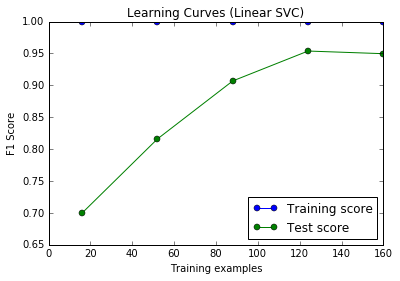

array([ 16,  52,  88, 124, 160])

In [78]:
plot_learning_curve(LSVC(), "Learning Curves (Linear SVC)", corpus)

### 5. Misclassified observations

In [103]:
def mislabel(data, k=5):
    
    # cross validation
    num_instances = len(data)
    num_in_fold = num_instances // 5
    
    rv = []
    model = GBC()
    
    for i in range(k):
        training_set = (data[0:i*num_in_fold] + 
                    data[(i+1)*num_in_fold:])
        test_set = data[i*num_in_fold: (i+1)*num_in_fold]
        
        vectorizer = TfidfVectorizer(analyzer = "word", stop_words = "english")
        
        X_train = vectorize(vectorizer, [' '.join(article) for article, tag in training_set], TRAIN)
        X_train = add_features(X_train, training_set)
        y_train = [tag for article, tag in training_set]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = vectorize(vectorizer, [' '.join(article) for article, tag in test_set], TEST)
        X_test = add_features(X_test, test_set)
        X_test = scaler.transform(X_test)
        y_true = [tag for article, tag in test_set]
                
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        for i in range(len(y_true)):
            rv.append((y_true[i]==y_pred[i], test_set[i]))
        
    return rv

In [105]:
results = mislabel(corpus)
correct = [a[1] for a in results if a[0]]
incorrect = [a[1] for a in results if not a[0]]

In [107]:
correct

[(['votes',
   'matter',
   'promise',
   'rests',
   'heart',
   'american',
   'democracy',
   'center',
   'american',
   'ideal',
   'many',
   'americans',
   'promise',
   'compromised',
   'even',
   'betrayed',
   'see',
   'right',
   'vote',
   'undermined',
   'nearly',
   'two',
   'dozen',
   'states',
   'recently',
   'adopted',
   'restrictions',
   'voter',
   'identification',
   'requirements',
   'limitations',
   'voter',
   'registration',
   'cutbacks',
   'early',
   'voting',
   'citizens',
   'see',
   'integrity',
   'vote',
   'compromised',
   'super',
   'rich',
   'giant',
   'corporations',
   'defining',
   'terms',
   'national',
   'state',
   'even',
   'municipal',
   'elections',
   'play',
   'outsized',
   'role',
   'runs',
   'office',
   'gets',
   'said',
   'campaigns',
   'wins',
   'policymakers',
   'willing',
   'developments',
   'follow',
   'two',
   'supreme',
   'court',
   'rulings',
   'skewed',
   'process',
   'shrank',
   'infl

### 6. Build the model

In [ ]:
def get_words_from_string(article):
    return [w.lower() for w in nltk.word_tokenize(article) if w.isalpha() and (w not in STOP_WORDS or w.lower() not in STOP_WORDS)]


def train(data):
    
    vectorizer = TfidfVectorizer(analyzer = "word", stop_words = "english", ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)
    X_train = vectorize(vectorizer, [' '.join(article + gen_pos_tag(article)) for article, tag in data], TRAIN)
    y_train = [tag for article, tag in data]
        
    clf = LSVC().fit(X_train, y_train)
        
    return clf, vectorizer


def predict_sample(article, vectorizer, clf):
    article = get_words_from_string(article)
    sample = vectorize(vectorizer, [' '.join(article + gen_pos_tag(article))], TEST)
    y_pred = clf.predict(sample)
    return y_pred

In [ ]:
clf, vectorizer = train(corpus)

In [ ]:
t = """Wheeler’s plan would start a lengthy process aimed at letting consumers buy cable boxes that could combine 
cable or satellite channels with content from providers such as Netflix, Amazon, Hulu and others, all in one box 
and all searchable. If you wanted to watch the movie American Sniper, for example, you could search for it and compare
prices to find the cheapest way to rent or buy it. Supporters of the idea hope bare-bones boxes would be available for
less than $50, while boxes with DVRs and other features would go for hundreds more."""
predict_sample(t, vectorizer, clf)

In [ ]:
t = """President Obama will crown his historic rapprochement with Cuba with a visit to the island as soon as March, 
the first for a sitting U.S. president in nearly 90 years, administration sources said Wednesday.
The White House will announce on Thursday the details of a multi-stop presidential trip to Latin America — including 
Cuba — in the coming weeks, said senior administration officials speaking on condition of anonymity because the 
official announcement had not been made. The trip was first reported by ABC News and Reuters."""
predict_sample(t, vectorizer, clf)